# Recurrent Neural Networks
---

Some useful resources that I'll be picking from throughout:

* [Deep Learning, Chapter 10](https://www.deeplearningbook.org/contents/rnn.html)
* [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [Fundamentals of Deep Learning](https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/) 

### Outline:

1. [Basic RNNs](#basicRNNs)
2. [Problem with Basic RNNs](#problems)
3. [Solution: Gated Networks (LSTM)](#lstm)
4. [Example in Keras](#keras)
5. [Bonus: Tensorboard](#tensorboard)



---
<a id='basicRNNs'></a>

## Basic RNNs
---

* Family of neural networks used for processing **sequential** data. 

<center><img src = "./figs/rnn_sequential_data.png" width = 600></center>

* Useful for:
    * NLP (Understanding the content/context of 1+ sentences)
    * Time-series data (forecasting)
    * Videos (together with CNNs)
    
    
* Typically presented as a 'folded' computational graph.

<center><img src = "./figs/rnn_unfolded.png" width = 600></center>

* These cycles represent the influence of the present value of a variable on its future value. 
    


---
<a id='problems'></a>

# Problems
---

* The biggest problem with RNNs is the vanishing (exploding) gradient problem.

<center><img src = "./figs/rnn_gradients.png" width = 600></center>

* When going back a long ways along an RNN (many time-steps), these 0's start to add up and the change in the gradient becomes miniscule.

* This leads to a very slow learning network.

<center><img src = "./figs/rnn_longterm.png" width = 600></center>

---
<a id='lstm'></a>

## Solution: Gated Networks
---

* Long Short Term Memory (LSTM) networks were developed to mitigate the problem of the gradient. 

<center><img src = "./figs/rnn_lstm1.png" width = 600></center>

* Designed specifically to 'remember' the long-term dependencies without changing them drastically. 

<center><img src = "./figs/rnn_lstm2.png" width = 600></center>

* Instead, the gates within the LSTM cell act to change the (relatively stable) long-term information. There are 3 gates:
    1. Forget Gate. <img style="float: right;" src = "./figs/rnn_lstm3.png" width = 300>
        
        * Ex. "Alice likes to ski. Bob likes to play the piano."  
        * Here, the network could 'forget' that Alice is the current subject, to be replaced with Bob. 
        
    2. Input Gate. <img style="float: right;" src = "./figs/rnn_lstm4.png" width = 300>
    
        * Ex. "Alice likes to ski. Alice also likes to kayak."
        * Here the network would add the new information about what Alice likes. 
        
    3. Output Gate. <img style="float: right;" src = "./figs/rnn_lstm5.png" width = 300>
        
        * Ex. "Bob grew up in France. Bob speaks fluent... "
        * Here the network might block all non-pertinent information, and only let 'France' pass through.
   
### Benefits of RNNs

* Once you have built a LSTM cell into your network you can then use it in conjunction with other layer types to complete your model. 
* You may wish to predict something at every timestep, or only predict something at the end of the series. Both are possible with RNNs. 
* This also allows for variable length sequences, which would not be possible with regular networks. 

---
<a id=keras></a>

## Keras Example
---

Let's look at an example of a model built using Keras (sorry, it's not physics based!) 

**Question:**
   * What salary should an NHL player receive based on past performance?
   * AND how long should the contract be?
   
**Data:**
   * Contract information from all NHL players over the last ~10 years. 
   
        * Length of contract
        * Percentage of the cap
        * What was their status when signing (UFA/RFA)
        * What was their age when signing
        
        
   * For each player, there is also some static information:
   
        * Handedness (left or right handed shooter)
        * Position (defense, center, right/left wing)
        
        
   * As well as a *time-series* of information that represents their individual stats from each year they have played.
        * Points, Goals, First Assists, ...
        * Corsi, Fenwick, ...
        * Time on Ice, etc.
        * 105 different stats total?
        
**Model:**
   * The plan is to build a LSTM architecture. This architecture will look at the individual stats over each season, and attempt to remember/identify the most important statistics over time. 
   * Concatenated to the end of the LSTM steps will be the static information that doesn't change from year to year. 
   * Because each player can have played for a variable number of years, having a malleable model that allows for different size series is quite useful!

## Import Things

Note that most of the code that I don't explicity include here is found in the [utils/training.py](./utils/training.py) file.

In [1]:
# My stuff
from utils.training import DataGenerator, Engine, plot_results, make_model

# Tensorflow and Keras stuff
from keras.optimizers import Adam
from keras import backend as K

# Regular stuff
import os
import numpy as np
import pandas as pd

# Plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pydot
import keras
keras.utils.vis_utils.pydot = pydot


Using TensorFlow backend.


## Import Data

In [2]:
# Import the data to train it with
# Note that this function takes care of normalizing everything
data_gen_cap = DataGenerator('./data/player_stats.csv',
                            './data/contract_stats_matched.csv',
                            './data/game_stats.csv',
                            prediction_type = 'cap_hit',
                            batch_size = 20)

data_gen_length = DataGenerator('./data/player_stats.csv',
                            './data/contract_stats_matched.csv',
                            './data/game_stats.csv',
                            prediction_type = 'length',
                            batch_size = 20)

C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [3]:
# Let's look at some of these stats
display(data_gen_cap.player_stats.head())

,player,team,date_of_birth,age,handed,center,left_wing,right_wing,defense,player_id
0,ALEX.OVECHKIN,WSH,"(17, 9, 1985)",33.0,1,0,1,1,0,0
1,HENRIK.ZETTERBERG,DET,"(9, 10, 1980)",38.0,0,1,0,0,0,1
2,JOHAN.FRANZEN,DET,"(23, 12, 1979)",39.0,0,0,1,1,0,2
3,MARIAN.HOSSA,ARI,"(12, 1, 1979)",40.0,0,0,0,1,0,3
4,DUNCAN.KEITH,CHI,"(16, 7, 1983)",35.0,0,0,0,0,1,4


In [14]:
display(data_gen_cap.game_stats.head())
display(data_gen_cap.game_stats.describe())

,player_id,player,season,position,player_season,G_EV,A1_EV,A2_EV,Points_EV,iSF_EV,...,TOI_avg,TOI_EV,TOI_PP,TOI_SH,EV_GAR,PP_GAR,SH_GAR,Pens_GAR,GAR,WAR
0,1649,AARON.JOHNSON,20072008,D,1649_20072008,0,0,1,1,13,...,13.860000,341.1,55.2,16.5,2.6,0.3,-0.1,-1.4,1.4,0.3
1,1618,MIKE.MODANO,20072008,F,1618_20072008,13,9,5,27,118,...,19.106098,1045.0,331.4,142.9,-5.6,1.5,1.0,1.0,-2.1,-0.4
2,1523,MIKE.LUNDIN,20072008,D,1523_20072008,0,2,4,6,33,...,13.793827,1044.3,11.2,51.0,4.4,-0.2,-1.2,1.5,4.4,0.9
3,2020,MIKE.KOMISAREK,20072008,D,2020_20072008,4,7,5,16,70,...,21.157333,1284.8,24.4,244.3,5.5,-0.8,-0.7,1.6,5.6,1.1
4,581,MIKE.GREEN,20072008,D,581_20072008,10,9,13,32,163,...,23.637805,1495.8,375.9,28.6,8.6,2.1,-0.1,4.5,15.2,2.9


,player_id,season,G_EV,A1_EV,A2_EV,Points_EV,iSF_EV,iCF_EV,iBLK_EV,iHF_EV,...,TOI_avg,TOI_EV,TOI_PP,TOI_SH,EV_GAR,PP_GAR,SH_GAR,Pens_GAR,GAR,WAR
count,8412.000000,8.412000e+03,8412.000000,8412.000000,8412.000000,8412.000000,8412.000000,8412.000000,8412.000000,8412.000000,...,8412.000000,8412.000000,8412.000000,8412.000000,8412.000000,8412.000000,8412.000000,8412.000000,8412.000000,8412.000000
mean,1058.072040,2.013178e+07,5.988825,5.624941,4.443771,16.057537,75.622563,140.277936,34.952330,64.883975,...,15.719044,756.869258,86.731907,67.604458,2.093117,0.549822,0.024406,0.496434,3.163160,0.601308
std,645.141962,3.327916e+04,5.849080,5.026002,3.625764,12.636877,50.352882,89.235497,31.457508,50.411608,...,4.546753,406.403283,94.571144,72.943850,4.247748,1.502587,0.920401,1.318735,5.537589,1.051369
min,0.000000,2.007201e+07,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-11.500000,-4.500000,-5.700000,-4.500000,-14.100000,-2.500000
25%,474.250000,2.010201e+07,1.000000,2.000000,1.000000,6.000000,34.000000,67.000000,13.000000,27.000000,...,12.668728,422.275000,5.400000,3.200000,-0.700000,-0.100000,-0.200000,-0.300000,-0.600000,-0.100000
50%,1133.000000,2.013201e+07,4.000000,4.000000,4.000000,13.000000,71.000000,135.000000,25.000000,53.000000,...,15.856637,800.750000,44.750000,39.550000,1.400000,0.000000,0.000000,0.300000,2.000000,0.400000
75%,1522.000000,2.016202e+07,9.000000,8.000000,7.000000,24.000000,109.000000,201.000000,46.000000,91.000000,...,18.836419,1075.225000,158.200000,118.725000,4.500000,1.000000,0.300000,1.125000,6.200000,1.200000
max,2510.000000,2.018202e+07,45.000000,38.000000,25.000000,77.000000,326.000000,659.000000,241.000000,379.000000,...,29.324390,1855.600000,456.700000,363.000000,19.400000,10.300000,5.000000,11.800000,36.300000,7.000000


In [13]:
display(data_gen_cap.contract_stats.head())

,name,signing_date,signing_age,signing_status,contract_type,length,cap_hit_pct,player_id
0,ALEX.OVECHKIN,"(10, 1, 2008)",22,0,STANDARD CONTRACT,13,0.1682,0
1,HENRIK.ZETTERBERG,"(7, 9, 2005)",24,1,STANDARD CONTRACT,4,0.0679,1
2,HENRIK.ZETTERBERG,"(28, 1, 2009)",28,1,STANDARD CONTRACT,12,0.1073,1
3,JOHAN.FRANZEN,"(4, 8, 2005)",25,0,STANDARD CONTRACT,1,0.0154,2
4,JOHAN.FRANZEN,"(25, 8, 2006)",26,0,STANDARD CONTRACT,3,0.0214,2


## Visualize Data

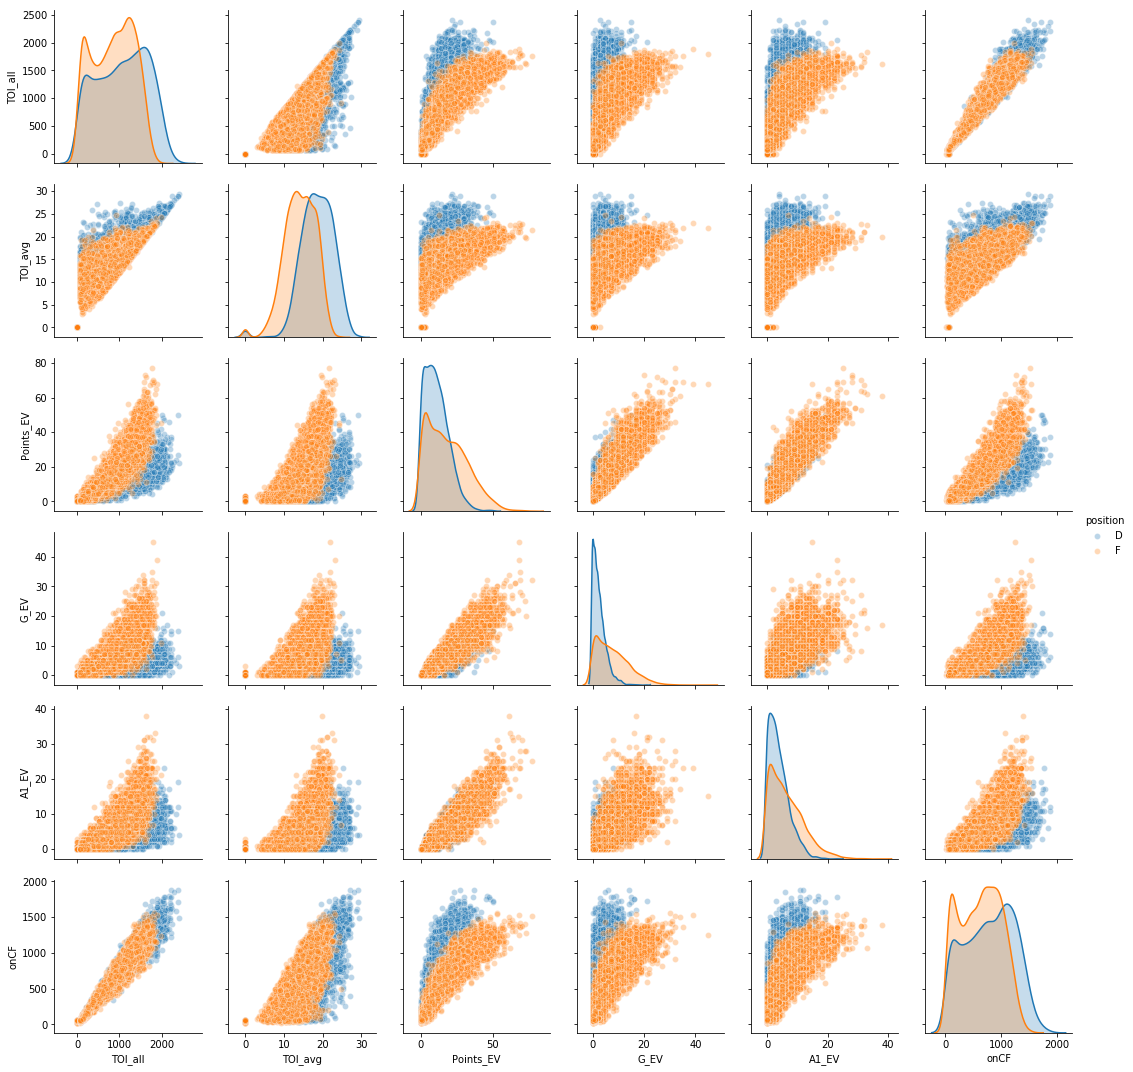

In [16]:
interesting_cols = ['TOI_all','TOI_avg','Points_EV','G_EV','A1_EV','onCF']
sns.pairplot(data_gen_cap.game_stats, 
             x_vars = interesting_cols, y_vars = interesting_cols, 
             hue = 'position', plot_kws = {'alpha':0.3})
plt.show()

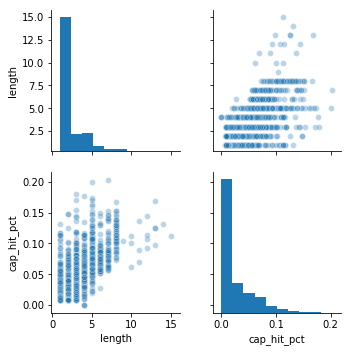

In [4]:
sns.pairplot(data=data_gen_cap.contract_stats, 
             x_vars=['length', 'cap_hit_pct'], y_vars=['length', 'cap_hit_pct'],
            plot_kws={'alpha':0.3})
plt.show()

## Create Model(s)

Note that in this case we need 2 models. 
One to predict cap hit, and another to predict contract length.

Also worth noting that length and cap_hit_pct are fairly correlated. So we use length as a feature when predicting cap_hit. This code can be found in training.py as well. 

```python
def make_model(prediction_type, lstm_layers, dense_layers, activation='relu'):
    """
    Produce LSTM models that can be used for prediction
    :param prediction_type: either cap_hit or length (as the output differs)
    :param lstm_layers: list of hidden nodes wanted for the lstm layers
    :param dense_layers: list of hidden nodes wanted for the dense layers
    :param activation: activation to use in the dense layers
    :return: model
    """
    num_game_features = 105
    if prediction_type == 'cap_hit':
        num_static_features = 8
        output_size = 1
    else:
        num_static_features = 7
        output_size = 8

    input_1 = Input(batch_shape=(None, None, num_game_features))
    input_2 = Input(batch_shape=(None, num_static_features))

    # Loop through all the LSTM Layers
    lstm_layer = LSTM(lstm_layers[0], return_sequences=True)(input_1)
    for hidden_size in lstm_layers[1:-1]:
        lstm_layer = LSTM(hidden_size, return_sequences=True)(lstm_layer)
    lstm_final = LSTM(lstm_layers[-1])(lstm_layer)

    # Add in the static info
    fc = Concatenate()([lstm_final, input_2])

    # Loop through all the Dense Layers
    for hidden_size in dense_layers:
        fc = Dense(hidden_size)(fc)
        fc = Activation(activation)(fc)

    out = Dense(output_size)(fc)

    if prediction_type == 'length':
        out = Activation('softmax')(out)

    # Create the actual model and return it
    model = Model(inputs=[input_1, input_2], outputs=out)

    return model
```

In [45]:
# Let's start with the length model.
model_length = make_model(prediction_type = 'length', 
                       lstm_layers = [64], 
                       dense_layers= [20],
                       activation = 'relu')

# Each model must also have an optimizer
optim = Adam()

In [46]:
# What does this model actually look like?
model_length.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 105)    0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, None, 64)     43520       input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 64)           33024       lstm_3[0][0]                     
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 7)            0                                            
__________________________________________________________________________________________________
concatenat

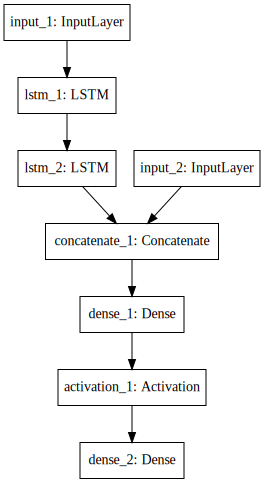

In [47]:
SVG(model_to_dot(model_cap).create(prog='dot', format='svg'))

## Train Model(s)

To train the model is pretty simple. I've wrapped it all up in an engine in the training.py file.

The main things we need to know from here are:

1. Create model.
2. Create optimizer.
3. Compile model with optimizer and any extra metrics. 
4. Choose callbacks.
5. Fit using either numpy arrays (.fit) or a data generator (.fit_generator)

```python
class Engine:
    def __init__(self, model, data_generator, optimizer, prediction_type):
        """
        Initialize model
        :param model: model to fit
        :param data_generator: data to fit
        :param optimizer: optimizer to use
        :param prediction_type: type of model to build (cap_hit or length)
        """
        self.history = None
        self.data_generator = data_generator
        self.prediction_type = prediction_type

        self.model = model
        self.optimizer = optimizer

        if self.prediction_type == 'cap_hit':
            self.model.compile(loss='mean_squared_error', optimizer=self.optimizer)
        else:
            self.model.compile(loss='categorical_crossentropy',
                               optimizer=self.optimizer,
                               metrics=[categorical_accuracy])
            
    def fit(self, epochs=10, tensorboard=False, early_stopping=False, verbose=2):
        """
        Fit the model using the given dataset
        :param epochs: number of epochs to run for
        :param tensorboard: whether or not to use the TB callback
        :param early_stopping: whether or not to use early stopping
        :param verbose: how much to print out each epoch
        :return:
        """
        val_x, val_y = self.data_generator.data_generation(self.data_generator.val_indices)
        callbacks = []

        # Check for callbacks to use
        if tensorboard:
            log_dir = new_run_log_dir(self.prediction_type+'_logs')
            callbacks.append(TensorBoard(log_dir=log_dir, histogram_freq=1))
        if early_stopping:
            callbacks.append(EarlyStopping(patience=3, restore_best_weights=True))

        self.history = self.model.fit_generator(self.data_generator,
                                                epochs=epochs,
                                                validation_data=(val_x, val_y),
                                                verbose=verbose,
                                                callbacks=callbacks)
```

In [48]:
# So let's load up an engine...
engine_length = Engine(model=model_length, 
                       data_generator=data_gen_length, 
                       optimizer=optim, 
                       prediction_type='length')

In [49]:
# And then train it!
# Here, we're going to use the early_stopping callback.
# This will literally halt the fit if the validation loss stops decreasing. 
# It can save many epochs of training!
engine_length.fit(epochs=30, 
                  early_stopping=True, 
                  verbose=1)

Epoch 1/30
120/120 [==============================] - 19s 158ms/step - loss: 1.5810 - categorical_accuracy: 0.4361 - val_loss: 1.3999 - val_categorical_accuracy: 0.4712
Epoch 2/30
120/120 [==============================] - 16s 137ms/step - loss: 1.3671 - categorical_accuracy: 0.4768 - val_loss: 1.3180 - val_categorical_accuracy: 0.4812
Epoch 3/30
120/120 [==============================] - 18s 148ms/step - loss: 1.3135 - categorical_accuracy: 0.4860 - val_loss: 1.3070 - val_categorical_accuracy: 0.4879
Epoch 4/30
120/120 [==============================] - 19s 159ms/step - loss: 1.2910 - categorical_accuracy: 0.4870 - val_loss: 1.3205 - val_categorical_accuracy: 0.4387
Epoch 5/30
120/120 [==============================] - 18s 151ms/step - loss: 1.2820 - categorical_accuracy: 0.4789 - val_loss: 1.2853 - val_categorical_accuracy: 0.4962
Epoch 6/30
120/120 [==============================] - 17s 142ms/step - loss: 1.2686 - categorical_accuracy: 0.4877 - val_loss: 1.2757 - val_categorical_acc

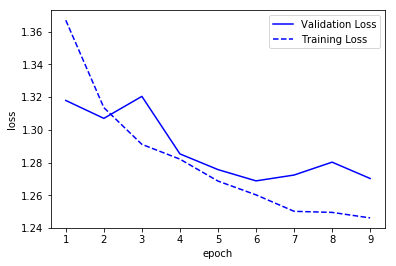

In [50]:
# I've also included a plotting helper function to see how the loss changed over the epochs. 
engine_length.plot_history(validation=True, 
                           display=True)

## Predict On Model(s)

In [56]:
# Let's make a prediction for his contract length!
predict = engine_length.predict(player_name='Mitchell Marner', 
                                signing_date=(4,7,2019), 
                                signing_status=0,
                                verbose=True)

Length: 1 ** Probability: 0.101
Length: 2 ** Probability: 0.124
Length: 3 ** Probability: 0.096
Length: 4 ** Probability: 0.105
Length: 5 ** Probability: 0.188
Length: 6 ** Probability: 0.101
Length: 7 ** Probability: 0.127
Length: 8 ** Probability: 0.159

Most likely contract length:  5


Epoch 1/30
120/120 [==============================] - 19s 161ms/step - loss: 0.0022 - val_loss: 8.1799e-04
Epoch 2/30
120/120 [==============================] - 17s 138ms/step - loss: 6.4465e-04 - val_loss: 6.4427e-04
Epoch 3/30
120/120 [==============================] - 19s 160ms/step - loss: 4.6501e-04 - val_loss: 3.9747e-04
Epoch 4/30
120/120 [==============================] - 18s 147ms/step - loss: 3.9520e-04 - val_loss: 3.3698e-04
Epoch 5/30
120/120 [==============================] - 16s 131ms/step - loss: 3.3862e-04 - val_loss: 2.8742e-04
Epoch 6/30
120/120 [==============================] - 16s 132ms/step - loss: 3.1939e-04 - val_loss: 3.3954e-04
Epoch 7/30
120/120 [==============================] - 16s 131ms/step - loss: 3.3789e-04 - val_loss: 3.1045e-04
Epoch 8/30
120/120 [==============================] - 15s 125ms/step - loss: 3.1163e-04 - val_loss: 3.4050e-04


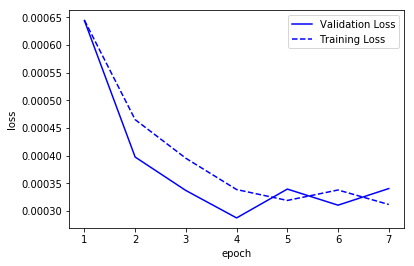

In [53]:
# Okay now that we've figured out the lengths, let's train the cap_hit model.
model_cap = make_model(prediction_type = 'cap_hit', 
                       lstm_layers = [64], 
                       dense_layers= [20],
                       activation = 'relu')

# Each model must also have an optimizer
optim = Adam()

engine_cap = Engine(model=model_cap, 
                    data_generator=data_gen_cap, 
                    optimizer=optim, 
                    prediction_type='cap_hit')

engine_cap.fit(epochs=30, 
               early_stopping=True, 
               verbose=1)

engine_cap.plot_history(validation=True, 
                        display=True)

In [55]:
# The contract length was predicted to be 5 years, so let's make a prediction based on that. 
predict = engine_cap.predict(player_name='Mitchell Marner', 
                             signing_date=(4,7,2019), 
                             signing_status=0,
                             length=5,
                             verbose=True)

Current Cap:           81.500 M
Total Contract Value:  28.746 M
Expected Cap Hit:      5.749 M
Percentage of Cap:     7.054 %


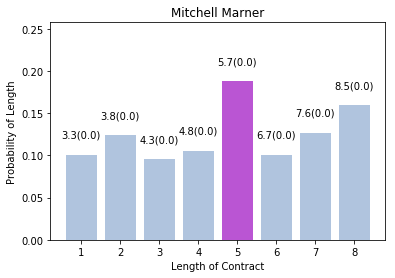

In [63]:
# And finally let's visualize the results in a slightly nicer plot. 
plot_results(player_name='Mitchell Marner', 
             signing_date=(5, 7, 2019), 
             signing_status=0, 
             engine_length=engine_length, 
             engine_cap=engine_cap,
             save_file=False)

We can also run multiple models and take averages over all the models to get slightly more statistical results. We won't do that here, but this is what it might look like...

<center><img src = "./figs/mitchell_marner.png" width = 400></center>


---
<a id='tensorboard'></a>

## Bonus: Tensorboard
---

* There's a cool callback you can use to watch your training in real-time, as well as gain information about how the weights are physically changing in each layer.

* The callback is:  
    ```python
    Tensorboard(log_dir=log_dir, histogram_freq=1, ...)
    ```


* Once a training session is running, open a different command line, and run:

    ```cmd
    tensorboard --logdir log_dir
    ```


* Then, in a browser, head to:

    ```cmd
     http://YOUR-DESKTOP:6006
     ```
     
From here, you should be able to see visualizations for every log_file in log_dir. Thus, if you do more than one run and save the logs here, they will all appear. These visualizations include:

* Scalars:
    * How the loss is changing (for both training/validation data).
    * How any other callbacks (like accuracy) are changing. 
    * I find this one the most intuitive/useful to view. Useful for seeing overfitting as it happens!
    
    <left><img src = "./figs/tensorboard_scalar_train.png" width = 312></left>
    <left><img src = "./figs/tensorboard_scalar_valid.png" width = 300></left>
    
    
* Graphs:
    * What does your current graph look like?
    
    
* Distributions
    * What is the distribution of weights for each layer?
    
    <left><img src = "./figs/tensorboard_dist.png" width = 500></left>
    
    
* Histograms
    * What are the histograms for each layer?
    
    <left><img src = "./figs/tensorboard_hist.png" width = 500></left>
    
Note that for the last 2, if you want the actual *weights* for each layer, you want the layers that don't say "layer_out", but just "layer". The "out" layers are the literal outputs (which I assume correspond to the actual outputs for the examples you are feeding in). 